# EGFR inhibitor

In [ ]:
# !pip install statsmodels git+https://github.com/sky1ove/katlas.git -q

In [ ]:
from katlas.core import *
import pandas as pd
from scipy.stats import ttest_rel
from tqdm import tqdm
import numpy as np 
from statsmodels.stats.multitest import multipletests
from katlas.core import *
from fastcore.basics import partial
from functools import reduce

In [ ]:
pd.set_option('display.precision', 15)

In [ ]:
def get_ttest(df, col1, col2, alpha=0.05, correction_method='fdr_bh',paired=False):
    """
    Performs t-tests and calculates log2 fold change between two groups in a DataFrame.
    NaN p-values are excluded from the multiple testing correction.

    Parameters:
    df (DataFrame): DataFrame with genes as index and patients as columns.
    col1, col2 (list): Column names for the two groups to compare.
    alpha (float): Significance level for multiple testing correction.
    correction_method (str): Method for multiple testing correction.

    Returns:
    DataFrame: Results including log2FC, p-values, adjusted p-values, and significance.
    """
    group1 = df[col1]
    group2 = df[col2]

    # Compute median values for each gene in both groups
    med1 = group1.median(axis=1)
    med2 = group2.median(axis=1)

    # Compute log2 fold change
    FCs = med2 - med1

    # Perform t-tests and handle NaN p-values
    if paired:
        t_results = [ttest_rel(group1.loc[gene], group2.loc[gene], nan_policy='omit') for gene in tqdm(df.index, desc="Computing t-tests")]
    else:
        t_results = [ttest_ind(group1.loc[gene], group2.loc[gene], nan_policy='omit') for gene in tqdm(df.index, desc="Computing t-tests")]

    
    p_values = [result.pvalue if result.pvalue is not np.nan else np.nan for result in t_results]

    # Exclude NaN p-values before multiple testing correction
    valid_p_values = np.array(p_values)
    valid_p_values = valid_p_values[~np.isnan(valid_p_values)]
    
    # Adjust for multiple testing on valid p-values only
    reject, pvals_corrected, _, _ = multipletests(valid_p_values, alpha=alpha, method=correction_method)
    
    # Create a full list of corrected p-values including NaNs for the excluded genes
    full_pvals_corrected = np.empty_like(p_values)
    full_pvals_corrected[:] = np.nan
    np.place(full_pvals_corrected, ~np.isnan(p_values), pvals_corrected)
    
    # Adjust the significance accordingly
    full_reject = np.zeros_like(p_values, dtype=bool)
    np.place(full_reject, ~np.isnan(p_values), reject)

    # Create DataFrame with results
    results = pd.DataFrame({
        'log2FC_median': FCs,
        'p_value': p_values,
        'p_adj': full_pvals_corrected,
        'significant': full_reject
    })

    results['p_value'] = results['p_value'].astype(float)
    
    return results

In [ ]:
df = pd.read_csv('raw/EGFRi.csv')

In [ ]:
df = df.dropna(subset='sequence').reset_index(drop=True)

In [ ]:
site_seq= extract_site_seq(df,'sequence','Predicted modification site')

100%|██████████| 15297/15297 [00:00<00:00, 29189.79it/s]


In [ ]:
df['site_seq'] = site_seq

In [ ]:
df['acceptor'] = df.site_seq.str[7]

In [ ]:
df.acceptor

0        S
1        T
2        E
3        S
4        S
        ..
15292    G
15293    T
15294    L
15295    L
15296    A
Name: acceptor, Length: 15297, dtype: object

In [ ]:
df = df[df.acceptor.isin(['S','T','Y'])].reset_index(drop=True)

In [ ]:
df['gene_site'] = df['Gene names']+'_'+df['Amino acid']+df['Predicted modification site'].astype(str)

## Get statistics

In [ ]:
ctrl = df.columns[df.columns.str.contains('DMSO')]

Gefitinib = df.columns[df.columns.str.contains('Gefitinib ')]

rescue = df.columns[df.columns.str.contains('GF2')] #FGF2

In [ ]:
gef = get_ttest(df,ctrl, Gefitinib,paired=True)
res = get_ttest(df,ctrl, rescue,paired=True)

Computing t-tests: 100%|██████████| 12862/12862 [00:01<00:00, 6603.00it/s]


In [ ]:
info = df[['gene_site','Gene names','site_seq','acceptor']]

In [ ]:
gef = pd.concat([info,gef],axis=1)
res = pd.concat([info,res],axis=1)

In [ ]:
def convert_p(r,p_col,FC_col):
    log10 = -np.log10(r[p_col])
    return -log10 if r[FC_col]<0 else log10

In [ ]:
gef['logP'] = gef.apply(convert_p,axis=1,args=('p_value','log2FC_median'))
res['logP'] = res.apply(convert_p,axis=1,args=('p_value','log2FC_median'))

In [ ]:
gef

,gene_site,Gene names,site_seq,acceptor,log2FC_median,p_value,p_adj,significant,logP
0,PFKFB2_S460,PFKFB2,SRPLKPLSPLRAQDM,S,-0.411400000000000,0.009404776524566,0.062883474582100,False,-2.026651519656484
1,PPP1R10_T256,PPP1R10,VAAPGDATPPAEKKY,T,-0.194299999999998,0.004797817815712,0.052779270137488,False,-2.318956247225443
2,PTPN13_S1033,PTPN13,SVASLNRSPERRKHE,S,-0.132400000000001,0.006299480705373,0.057559446552550,False,-2.200695249925201
3,PPIP5K1_S1128,PPIP5K1,SPPRTLHSPPLQLQQ,S,-0.116900000000001,0.005728096413435,0.056240287076028,False,-2.241989680736819
4,PFKFB2_S433,PFKFB2,PVRMRRNSFTPLSSS,S,-0.549199999999999,0.013011267543891,0.068888184327048,False,-1.885680392869417
...,...,...,...,...,...,...,...,...,...
12857,IFI16_T105,IFI16,RKKEVDATSPAPSTS,T,-0.097784220000001,0.067657362800887,0.146771631024626,False,-1.169684934472127
12858,VRK3_T58,VRK3,GLNSSFETSPKKVKW,T,-0.303802659999999,0.025538164948660,0.088992651739275,False,-1.592810312291981
12859,ACIN1_S855,ACIN1,VDLHADDSRISEDET,S,-0.119704189999998,0.117221935320113,0.207771383576998,False,-0.930991112745326
12860,EIF4EBP2_Y34,EIF4EBP2,AAQLPHDYCTTPGGT,Y,-0.028873040000001,0.728105386719584,0.794308013909015,False,-0.137805755909072


In [ ]:
res

,gene_site,Gene names,site_seq,acceptor,log2FC_median,p_value,p_adj,significant,logP
0,PFKFB2_S460,PFKFB2,SRPLKPLSPLRAQDM,S,-0.571100000000001,0.010885152394412,0.102560660382255,False,-1.963165486366679
1,PPP1R10_T256,PPP1R10,VAAPGDATPPAEKKY,T,-0.144900000000000,0.033989101872159,0.143875289566430,False,-1.468660311060329
2,PTPN13_S1033,PTPN13,SVASLNRSPERRKHE,S,-0.106100000000001,0.004889594721472,0.092214028310217,False,-2.310727136279793
3,PPIP5K1_S1128,PPIP5K1,SPPRTLHSPPLQLQQ,S,-0.118400000000001,0.000618075304278,0.076822178718779,False,-3.208958608665317
4,PFKFB2_S433,PFKFB2,PVRMRRNSFTPLSSS,S,-0.558900000000001,0.011286478409450,0.103755450660386,False,-1.947441544870461
...,...,...,...,...,...,...,...,...,...
12857,IFI16_T105,IFI16,RKKEVDATSPAPSTS,T,0.082868879999999,0.590084697285980,0.696619493023614,False,0.229085647808773
12858,VRK3_T58,VRK3,GLNSSFETSPKKVKW,T,0.022645590000000,0.842186602580849,0.890440121857368,False,0.074591671573422
12859,ACIN1_S855,ACIN1,VDLHADDSRISEDET,S,0.048446770000002,0.105263290981413,0.237671314038753,False,0.977723056200508
12860,EIF4EBP2_Y34,EIF4EBP2,AAQLPHDYCTTPGGT,Y,0.069084609999999,0.239858409824558,0.382619231943875,False,0.620045049862791


In [ ]:
def preprocess_seq(seq):
    # Convert non-sty to capital
    seq2 = ''.join([char.upper() if char not in ['s', 't', 'y'] else char for char in seq])
    
    # Convert rare amino acids to "_"
    allowed_chars = set('PGACSTVILMFYWHKRQNDEsty')  # Corrected to set of individual characters
    
    seq3 = ''.join(char if char in allowed_chars else '_' for char in seq2)
    
    return seq3

In [ ]:
gef['site_seq2'] = gef['site_seq'].apply(preprocess_seq)
res['site_seq2'] = res['site_seq'].apply(preprocess_seq)

## Get kinase score

In [ ]:
ref = Data.get_cddm_upper()

In [ ]:
out_gef = predict_kinase_df(gef,seq_col='site_seq2', **param_CDDM_upper)
out_res = predict_kinase_df(res,seq_col='site_seq2', **param_CDDM_upper)

input dataframe has a length 12862
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:15<00:00, 18.18it/s]


input dataframe has a length 12862
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:15<00:00, 18.21it/s]


## Gene analysis

In [ ]:
def get_max(x):
    x = x.dropna().sort_values().values
    return x[0] if abs(x[0])>abs(x[-1]) else x[-1]

### Y site related genes

In [ ]:
gef_y = gef.query('acceptor=="Y"')

In [ ]:
y_gene = gef_y.groupby('Gene names').\
agg({'logP':get_max,'gene_site':'count'}).reset_index().sort_values('logP',ascending=False)

In [ ]:
y_gene['gene'] = y_gene['Gene names'].str.split(';')

In [ ]:
y_gene = y_gene.explode('gene')

In [ ]:
y_gene.sort_values('logP')

,Gene names,logP,gene_site,gene
52,EPHA2,-4.395560016386867,3,EPHA2
44,EGFR,-2.681299351560108,4,EGFR
71,LARP4,-2.513855011976424,1,LARP4
77,MAPK3,-2.477587987691505,1,MAPK3
94,NUP50,-2.476328508124554,1,NUP50
...,...,...,...,...
81,MNT,3.121652305389536,1,MNT
130,SCEL,3.205569524750531,1,SCEL
68,KIAA1377,3.319012460936964,1,KIAA1377
145,SYNPO,3.575317870526453,1,SYNPO


In [ ]:
# y_gene.query('logP>1.3 or logP<-1.3').to_csv('EGFR_y.csv',index=False)

### All sites' genes

In [ ]:
gef_gene = gef.groupby('Gene names').\
agg({'logP':get_max,'gene_site':'count'}).reset_index().sort_values('logP',ascending=False)
res_gene = res.groupby('Gene names').\
agg({'logP':get_max,'gene_site':'count'}).reset_index().sort_values('logP',ascending=False)

In [ ]:
gef_gene['gene'] = gef_gene['Gene names'].str.split(';')
res_gene['gene'] = res_gene['Gene names'].str.split(';')

In [ ]:
gef_gene = gef_gene.explode('gene')
res_gene = res_gene.explode('gene')

In [ ]:
gef_gene.sort_values('logP')

,Gene names,logP,gene_site,gene
223,ATXN2L,-5.451550380478368,13,ATXN2L
1914,NSRP1,-5.006113730614310,6,NSRP1
1071,FOXP4,-5.002570510327538,1,FOXP4
263,BCL9,-4.797320716845226,6,BCL9
2960,TMEM154,-4.793280507844569,4,TMEM154
...,...,...,...,...
2085,PI4KB,4.459500808533400,6,PI4KB
1588,MAP1S,4.609132540302896,1,MAP1S
1765,MTMR3,4.841903888974026,7,MTMR3
2785,SRSF5,4.941546262499168,7,SRSF5


In [ ]:
res_gene.sort_values('logP')

,Gene names,logP,gene_site,gene
1154,GPATCH8,-5.329530133552300,7,GPATCH8
5,AAK1,-5.177795040555558,17,AAK1
3047,TRIO,-5.052566310524711,10,TRIO
658,CTNNA1;CTNNA2,-4.529622341568680,5,CTNNA2
658,CTNNA1;CTNNA2,-4.529622341568680,5,CTNNA1
...,...,...,...,...
547,CHD4,4.036925136879221,16,CHD4
921,ERF,4.047973491779127,9,ERF
502,CDS2,4.495182024109076,4,CDS2
2554,SDPR,4.633300864754712,6,SDPR


In [ ]:
# gef_gene.query('logP>1.3 or logP<-1.3').to_csv('EGFRi_pthway.csv')

## Kinase analysis

In [ ]:
info = Data.get_kinase_info().rename(columns={'ID_HGNC':'gene'}).query('pseudo=="0"')

In [ ]:
gef_kinase = gef_gene.merge(info)
res_kinase = res_gene.merge(info)

In [ ]:
gef_kinase[['kinase','logP']].merge(res_kinase[['kinase','logP']])

,kinase,logP


In [ ]:
r = res_kinase[['kinase','logP']].rename(columns={'logP':'logP_rescue'})

In [ ]:
g = gef_kinase[['kinase','logP']].rename(columns={'logP':'logP_inhibitor'})

In [ ]:
comb = r.merge(g,'outer').fillna(0)

In [ ]:
comb['diff'] = comb['logP_rescue'] - comb['logP_inhibitor']

In [ ]:
comb = comb.sort_values('diff',ascending=False)

In [ ]:
data = comb.set_index('kinase')[['logP_inhibitor','logP_rescue']]

In [ ]:
data.columns = ['EGFR inhibitor','Rescue']

In [ ]:
data2 = pd.concat([data.head(5),data.tail(5)])

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

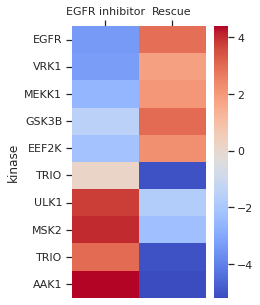

In [ ]:
plt.figure(figsize=(3,5))
ax = sns.heatmap(data2, cmap='coolwarm')
ax.xaxis.tick_top()

In [ ]:
gef_kinase.sort_values('logP')

,Gene names,logP,gene_site,gene,kinase,ID_coral,uniprot,group,family,subfamily_coral,...,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
199,EPHA2,-4.395560016386867,11,EPHA2,EPHA2,EphA2,P29317,TK,Eph,None,...,1.0,NaN,1.0,NaN,3.0,NaN,5.0,NaN,NaN,vesicle
198,LATS1,-4.075539959654573,9,LATS1,LATS1,LATS1,O95835,AGC,NDR,None,...,5.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,cytosol
197,EGFR,-3.375942139227799,12,EGFR,EGFR,EGFR,P00533,TK,EGFR,None,...,1.0,NaN,4.0,NaN,3.0,NaN,2.0,NaN,NaN,plasma membrane
196,CLK3,-3.354945002675939,6,CLK3,CLK3,CLK3,P49761,CMGC,CLK,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
195,VRK1,-3.279171705963572,2,VRK1,VRK1,VRK1,Q99986,CK1,VRK,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,ULK1,3.769195056182373,9,ULK1,ULK1,ULK1,O75385,Other,ULK,None,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,cytosol
3,CDK12,3.824071784675893,29,CDK12,CDK12,CRK7,Q9NYV4,CMGC,CDK,CRK7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
2,MYLK,3.932547906888627,8,MYLK,SMMLCK,smMLCK,Q15746,CAMK,MLCK,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,RPS6KA4,4.021079509856269,4,RPS6KA4,MSK2,MSK2,O75676,AGC,RSK,MSK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [ ]:
res_kinase.sort_values('logP')

,Gene names,logP,gene_site,gene,kinase,ID_coral,uniprot,group,family,subfamily_coral,...,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
199,AAK1,-5.177795040555558,17,AAK1,AAK1,AAK1,Q2M2I8,Other,NAK,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
57,TRIO,-5.052566310524711,10,TRIO,TRIO,Trio,O75962,CAMK,Trio,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
198,STK10,-3.991645783940854,9,STK10,LOK,LOK,O94804,STE,STE20,SLK,...,8.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
197,MAPK1,-3.409822855504664,3,MAPK1,ERK2,Erk2,P28482,CMGC,MAPK,ERK1,...,6.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
196,MAP2K2,-3.144161251914382,5,MAP2K2,MEK2,MAP2K2,P36507,STE,STE7,None,...,7.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,EGFR,2.914993589471452,12,EGFR,EGFR,EGFR,P00533,TK,EGFR,None,...,1.0,NaN,4.0,NaN,3.0,NaN,2.0,NaN,NaN,plasma membrane
3,GSK3B,3.000472636916385,4,GSK3B,GSK3B,GSK3B,P49841,CMGC,GSK,None,...,9.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
2,MARK2,3.275888606341437,17,MARK2,MARK2,MARK2,Q7KZI7,CAMK,CAMKL,MARK,...,2.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,plasma membrane
1,PAK2,3.391546012847004,7,PAK2,PAK2,PAK2,Q13177,STE,STE20,PAKA,...,6.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol


## Predicted kinase analysis

In [ ]:
def top_kinases(site_row,top_n=5):
    # Sort the row in descending order and get the top 5 kinases
    top_kinases = site_row.sort_values(ascending=False).head(top_n)
    
    # Get the counts of the top kinases
    kinase_counts = top_kinases.index.value_counts()
    
    return kinase_counts

def get_result(site,site_score,is_Y=True,top_n = 5):
    
    if is_Y:
        idx_up = site.index[(site.acceptor.str.upper()=="Y") & (site['logP']>1.3)]
        idx_dn = site.index[(site.acceptor.str.upper()=="Y") & (site['logP']<-1.3)]
    else:
        idx_up = site.index[(site.acceptor.str.upper()!="Y") & (site['logP']>1.3)]
        idx_dn = site.index[(site.acceptor.str.upper()!="Y") & (site['logP']<-1.3)]
    
    up_site = site.loc[idx_up]
    dn_site = site.loc[idx_dn]

    up_score = site_score.loc[idx_up]
    dn_score = site_score.loc[idx_dn]
    
    func = partial(top_kinases,top_n=top_n)
    
    up_cnt = up_score.apply(func,axis=1)
    dn_cnt = dn_score.apply(func,axis=1)
    
    df_up_cnt = up_cnt.sum().reset_index(name = 'up_cnt')
    df_dn_cnt = dn_cnt.sum().reset_index(name = 'dn_cnt')
    
    df_w_up = up_cnt.multiply(abs(up_site['logP']),axis=0).sum().reset_index(name = 'up_weighted_cnt')
    df_w_dn = dn_cnt.multiply(abs(dn_site['logP']),axis=0).sum().reset_index(name = 'dn_weighted_cnt')
    
    dfs = [df_up_cnt,df_dn_cnt,df_w_up,df_w_dn]
    
    result = reduce(lambda left, right: pd.merge(left, right, how='outer'), dfs)
    
    result = result.fillna(0)
    result['enrich'] = result.apply(lambda r: r.up_weighted_cnt if r.up_weighted_cnt >= r.dn_weighted_cnt else -r.dn_weighted_cnt,axis=1)
    result['change'] = result.up_weighted_cnt - result.dn_weighted_cnt
    
    
    return result

In [ ]:
st_gef = get_result(gef,out_gef,is_Y=False,top_n=10)
st_res = get_result(res,out_res,is_Y=False,top_n=10)

In [ ]:
# st_gef.sort_values('change').to_csv('st_site.csv',index=False)

In [ ]:
st_res.sort_values('enrich')

,index,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,change
52,ERK2,659.0,942.0,1206.771343062176356,1843.947457302230305,-1843.947457302230305,-637.176114240053948
28,CDK4,647.0,907.0,1181.446714565414823,1779.130341437361722,-1779.130341437361722,-597.683626871946899
25,CDK1,647.0,887.0,1180.425494750816370,1746.201701322628878,-1746.201701322628878,-565.776206571812509
51,ERK1,595.0,865.0,1092.275951040171776,1693.708919325539910,-1693.708919325539910,-601.432968285368133
26,CDK2,600.0,772.0,1098.114259969430805,1532.415512728139447,-1532.415512728139447,-434.301252758708642
...,...,...,...,...,...,...,...
172,TAO1,28.0,27.0,50.695439511809653,46.230258590745947,50.695439511809653,4.465180921063705
36,CK1D,32.0,26.0,64.481062659539845,55.718341538969540,64.481062659539845,8.762721120570305
38,CK1G1,101.0,97.0,192.694917499798549,188.493047187856348,192.694917499798549,4.201870311942201
58,GRK5,133.0,119.0,249.727702119870798,231.158329566057489,249.727702119870798,18.569372553813309


In [ ]:
y_gef = get_result(gef,out_gef)
y_res = get_result(res,out_res)

In [ ]:
y_gef[['index','enrich']].sort_values('enrich').head()

,index,enrich
8,EGFR,-22.660474684791780
37,PTK2,-17.601779795319533
40,SYK,-14.823808262953897
61,TEC,-14.492538350096163
26,JAK2,-14.151111829278207


In [ ]:
# y_gef.sort_values('enrich').to_csv('y_site.csv',index=False)

In [ ]:
y_gef.sort_values('enrich').head()

,index,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,change
8,EGFR,6.0,12.0,13.266529358805141,22.660474684791780,-22.660474684791780,-9.393945325986639
37,PTK2,6.0,9.0,13.815052639845526,17.601779795319533,-17.601779795319533,-3.786727155474008
40,SYK,3.0,8.0,4.447741361409966,14.823808262953897,-14.823808262953897,-10.376066901543931
61,TEC,0.0,7.0,0.000000000000000,14.492538350096163,-14.492538350096163,-14.492538350096163
26,JAK2,3.0,8.0,4.741518606436122,14.151111829278207,-14.151111829278207,-9.409593222842085


In [ ]:
y_gef.rename(columns={'index':'kinase'}).merge(info).query('group=="TK"').sort_values('enrich').head()

,kinase,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,change,ID_coral,uniprot,gene,...,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
8,EGFR,6.0,12.0,13.266529358805141,22.660474684791780,-22.660474684791780,-9.393945325986639,EGFR,P00533,EGFR,...,1.0,NaN,4.0,NaN,3.0,NaN,2.0,NaN,NaN,plasma membrane
37,PTK2,6.0,9.0,13.815052639845526,17.601779795319533,-17.601779795319533,-3.786727155474008,FAK,Q05397,PTK2,...,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
40,SYK,3.0,8.0,4.447741361409966,14.823808262953897,-14.823808262953897,-10.376066901543931,SYK,P43405,SYK,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,plasma membrane
61,TEC,0.0,7.0,0.000000000000000,14.492538350096163,-14.492538350096163,-14.492538350096163,TEC,P42680,TEC,...,2.0,NaN,2.0,NaN,NaN,NaN,6.0,NaN,NaN,vesicle
26,JAK2,3.0,8.0,4.741518606436122,14.151111829278207,-14.151111829278207,-9.409593222842085,JAK2,O60674,JAK2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [ ]:
y_res.sort_values('enrich').head()

,index,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,change
10,EGFR,1.0,8.0,1.367396945681889,18.999530033958838,-18.999530033958838,-17.632133088276948
42,ZAP70,5.0,7.0,8.911715138182505,15.877849859804186,-15.877849859804186,-6.966134721621682
19,FGFR4,3.0,6.0,6.125957856454246,13.459875357179154,-13.459875357179154,-7.333917500724908
16,ERBB4,2.0,6.0,2.692285200073242,12.872425552742161,-12.872425552742161,-10.180140352668920
27,KIT,4.0,5.0,6.684985233674544,12.821650502381985,-12.821650502381985,-6.136665268707441
